# FASTVIT PET MOBILE

## 1. Environment setup

In [1]:
!git clone https://github.com/HenryNVP/fastvit-pet-mobile.git
%cd fastvit-pet-mobile

Cloning into 'fastvit-pet-mobile'...
remote: Enumerating objects: 123, done.
remote: Counting objects: 100% (123/123), done.
remote: Compressing objects: 100% (93/93), done.
remote: Total 123 (delta 46), reused 80 (delta 21), pack-reused 0 (from 0)
Receiving objects: 100% (123/123), 3.33 MiB | 8.84 MiB/s, done.
Resolving deltas: 100% (46/46), done.
/content/fastvit-pet-mobile


In [2]:
!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 132.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 10.5 MB/s eta 0:00:00


## 2. Download and prepare data

This downloads the official dataset and prepares 256x256 splits.

In [3]:
!python scripts/get_data.py
!python scripts/split_dataset.py

/content/fastvit-pet-mobile/scripts/get_data.py:33: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tf.extractall(destination)
Prepared train=3680 val=1832 test=1837


## 2. Baseline model

In [4]:
# Download and load checkpoint
!wget -O fastvit_t8.pth.tar \
"https://docs-assets.developer.apple.com/ml-research/models/fastvit/image_classification_models/fastvit_t8.pth.tar"

--2025-11-27 02:52:18--  https://docs-assets.developer.apple.com/ml-research/models/fastvit/image_classification_models/fastvit_t8.pth.tar
Resolving docs-assets.developer.apple.com (docs-assets.developer.apple.com)... 17.253.83.138, 17.253.83.133, 2620:149:a21:f000::146, ...
Connecting to docs-assets.developer.apple.com (docs-assets.developer.apple.com)|17.253.83.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16378213 (16M) [application/x-tar]
Saving to: ‘fastvit_t8.pth.tar’

fastvit_t8.pth.tar  100%[===================>]  15.62M  52.4MB/s    in 0.3s    

2025-11-27 02:52:19 (52.4 MB/s) - ‘fastvit_t8.pth.tar’ saved [16378213/16378213]



In [9]:
!python fastvit/train.py data \
    --model fastvit_t8 \
    --resume fastvit_t8.pth.tar \
    --finetune \
    --freeze-stages 0 1 2 \
    --num-classes 37 \
    -b 192 --lr 1e-3 \
    --epochs 40 \
    --native-amp \
    --output ./output \
    --input-size 3 256 256

Current content:
# Fix fastvit/__init__.py - remove incorrect imports
import os

fastvit_init_path = 'fastvit/__init__.py'

# Read current file to see what's wrong
if os.path.exists(fastvit_init_path):
    with open(fastvit_init_path, 'r') as f:
        content = f.read()
    print("Current content:")
    print(content[:500])  # Show first 500 chars
    print("\n" + "="*50)
    
# Write the correct minimal version
correct_content = '''#
# For licensing see accompanying LICENSE file.
# Copyright (C) 2023 Apple In

✅ Fixed fastvit/__init__.py

Now try running your training command again!
/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.12/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated,

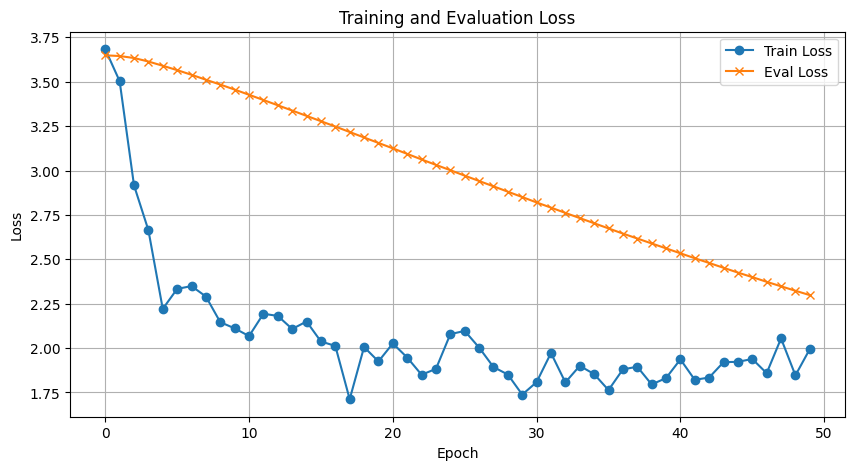

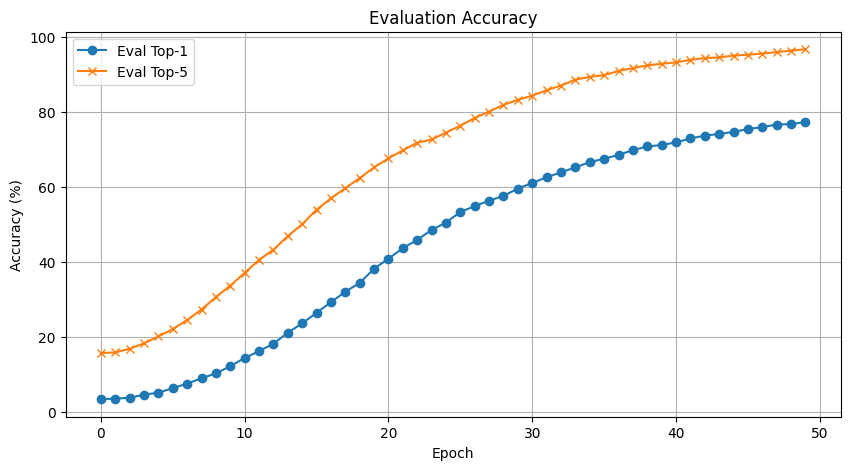

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV summary
summary_path = '/content/fastvit-pet-mobile/output/20251127-031028-fastvit_t8-256/summary.csv'
df = pd.read_csv(summary_path)

# Plot training and evaluation loss
plt.figure(figsize=(10,5))
plt.plot(df['epoch'], df['train_loss'], label='Train Loss', marker='o')
plt.plot(df['epoch'], df['eval_loss'], label='Eval Loss', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot evaluation Top-1 and Top-5 accuracy
plt.figure(figsize=(10,5))
plt.plot(df['epoch'], df['eval_top1'], label='Eval Top-1', marker='o')
plt.plot(df['epoch'], df['eval_top5'], label='Eval Top-5', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Evaluation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# Quick fix
with open('fastvit/__init__.py', 'w') as f: f.write('#\n# For licensing see accompanying LICENSE file.\n# Copyright (C) 2023 Apple Inc. All rights reserved.\n#\n# FastViT Package\n# This package should be imported via: import fastvit.models as models\n# All model imports should be in fastvit/models/__init__.py\n')
print("✅ Fixed!")

✅ Fixed!


In [13]:
from timm.models import create_model, load_checkpoint
import fastvit.models as models
from fastvit.models.modules.mobileone import reparameterize_model

baseline_model = create_model(
    "fastvit_t8",
    pretrained=False,
    num_classes=37,
)

load_checkpoint(baseline_model, "/content/fastvit-pet-mobile/output/20251127-031028-fastvit_t8-256/model_best.pth.tar", use_ema=True)

baseline_model.eval()
baseline_model = reparameterize_model(baseline_model)
baseline_model = baseline_model.cuda()

/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.12/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/content/fastvit-pet-mobile/fastvit/models/fastvit.py:956: UserWarning: Overwriting fastvit_t8 in registry with fastvit.models.fastvit.fastvit_t8. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @register_model
/content/fastvit-pet-mobile/fastvit/models/fastvit.py:978: UserWarning: Overwriting fastvit_t12 in registry with fastvit.models.fastvit.fastvit_t12. This is because the name bein

If for semantic segmentation, please install mmsegmentation first
If for detection, please install mmdetection first


In [18]:
import torch
from PIL import Image
from torchvision import transforms

# Load image
img = Image.open("/content/fastvit-pet-mobile/data/test/Birman/Birman_75.jpg").convert("RGB")

# Preprocessing
preprocess = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

input_tensor = preprocess(img).unsqueeze(0).to("cuda")  # add batch dimension

with torch.no_grad():
    output = baseline_model(input_tensor)  # shape: [1, num_classes]
    predicted_class = torch.argmax(output, dim=1)
    print("Predicted class index:", predicted_class.item())

Predicted class index: 32


In [20]:
!python fastvit/validate.py data \
    --model fastvit_t8 \
    --checkpoint /content/fastvit-pet-mobile/output/20251127-031028-fastvit_t8-256/model_best.pth.tar \
    --num-classes 37 \
    --batch-size 128 \
    --input-size 3 256 256 \
    --split test \
    --use-ema \
    --native-amp

/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.12/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
If for semantic segmentation, please install mmsegmentation first
If for detection, please install mmdetection first
/content/fastvit-pet-mobile/fastvit/models/fastvit.py:956: UserWarning: Overwriting fastvit_t8 in registry with fastvit.models.fastvit.fastvit_t8. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @register_model
/content/fastvit-pet-mobile/fastvit/models/fastvit.py:978: Us

## 3. Finetune teacher model

In [ ]:
# Download and load checkpoint
!wget -O fastvit_t8.pth.tar \
"https://docs-assets.developer.apple.com/ml-research/models/fastvit/image_classification_models/fastvit_t8.pth.tar"

--2025-11-19 23:33:32--  https://docs-assets.developer.apple.com/ml-research/models/fastvit/image_classification_models/fastvit_t8.pth.tar
Resolving docs-assets.developer.apple.com (docs-assets.developer.apple.com)... 17.253.85.203, 17.253.85.206, 2403:300:a32:f000::1, ...
Connecting to docs-assets.developer.apple.com (docs-assets.developer.apple.com)|17.253.85.203|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16378213 (16M) [application/x-tar]
Saving to: ‘fastvit_t8.pth.tar’

fastvit_t8.pth.tar  100%[===================>]  15.62M  30.8MB/s    in 0.5s    

2025-11-19 23:33:33 (30.8 MB/s) - ‘fastvit_t8.pth.tar’ saved [16378213/16378213]



In [ ]:
!python fastvit/train.py data \
    --model fastvit_t8 \
    --resume fastvit_t8.pth.tar \
    --finetune \
    --freeze-stages 0 1 2 3 \
    --num-classes 37 \
    -b 192 --lr 1e-3 \
    --epochs 20 \
    --native-amp \
    --output ./output \
    --input-size 3 256 256

/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.12/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
If for semantic segmentation, please install mmsegmentation first
If for detection, please install mmdetection first
/content/fastvit-pet-mobile/fastvit/models/fastvit.py:956: UserWarning: Overwriting fastvit_t8 in registry with fastvit.models.fastvit.fastvit_t8. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @register_model
/content/fastvit-pet-mobile/fastvit/models/fastvit.py:978: Us

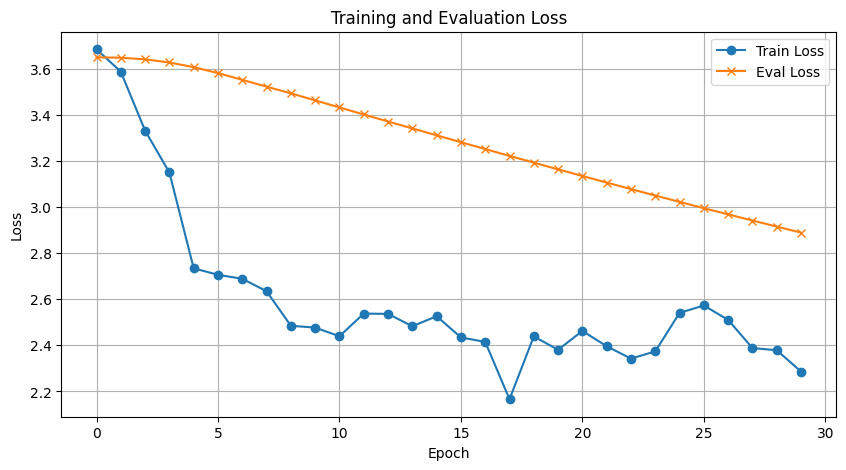

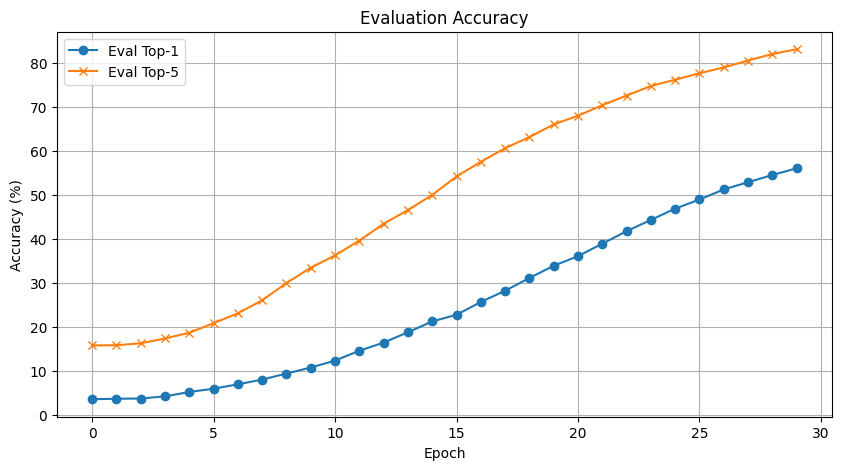

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV summary
summary_path = '/content/fastvit-pet-mobile/output/20251119-233915-fastvit_t8-256/summary.csv'
df = pd.read_csv(summary_path)

# Plot training and evaluation loss
plt.figure(figsize=(10,5))
plt.plot(df['epoch'], df['train_loss'], label='Train Loss', marker='o')
plt.plot(df['epoch'], df['eval_loss'], label='Eval Loss', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot evaluation Top-1 and Top-5 accuracy
plt.figure(figsize=(10,5))
plt.plot(df['epoch'], df['eval_top1'], label='Eval Top-1', marker='o')
plt.plot(df['epoch'], df['eval_top5'], label='Eval Top-5', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Evaluation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from timm.models import create_model, load_checkpoint
import fastvit.models as models
from fastvit.models.modules.mobileone import reparameterize_model

tuned_teacher = create_model(
    "fastvit_t8",
    pretrained=False,
    num_classes=37,
)

load_checkpoint(tuned_teacher, "/content/fastvit-pet-mobile/output/20251119-233915-fastvit_t8-256/model_best.pth.tar", use_ema=False)

tuned_teacher.eval()
tuned_teacher = reparameterize_model(tuned_teacher)
tuned_teacher = tuned_teacher.cuda()


In [ ]:
from PIL import Image
from torchvision import transforms

# Load image
img = Image.open("/content/fastvit-pet-mobile/data/test/Birman/Birman_75.jpg").convert("RGB")

# Preprocessing
preprocess = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

input_tensor = preprocess(img).unsqueeze(0).to("cuda")  # add batch dimension

with torch.no_grad():
    output = tuned_teacher(input_tensor)  # shape: [1, num_classes]
    predicted_class = torch.argmax(output, dim=1)
    print("Predicted class index:", predicted_class.item())

Predicted class index: 6


In [ ]:
!python fastvit/validate.py data \
    --model fastvit_t8 \
    --checkpoint /content/fastvit-pet-mobile/output/20251119-233915-fastvit_t8-256/model_best.pth.tar \
    --num-classes 37 \
    --batch-size 128 \
    --input-size 3 256 256 \
    --split test \
    --use-ema \
    --native-amp

/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.12/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
If for semantic segmentation, please install mmsegmentation first
If for detection, please install mmdetection first
/content/fastvit-pet-mobile/fastvit/models/fastvit.py:956: UserWarning: Overwriting fastvit_t8 in registry with fastvit.models.fastvit.fastvit_t8. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @register_model
/content/fastvit-pet-mobile/fastvit/models/fastvit.py:978: Us

## 4. Setup and finetune student model

## 5. Model evaluation

## 6. Export model

In [ ]:
!pip install onnx onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 72.4 MB/s eta 0:00:00


In [ ]:
!python scripts/export_models.py \
    --checkpoint output/20251119-233915-fastvit_t8-256/model_best.pth.tar \
    --model fastvit_t8 \
    --num-classes 37 \
    --input-size 256 \
    --reparameterize \
    --subdir teacher

/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.12/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
If for semantic segmentation, please install mmsegmentation first
If for detection, please install mmdetection first
/content/fastvit-pet-mobile/fastvit/models/fastvit.py:956: UserWarning: Overwriting fastvit_t8 in registry with fastvit.models.fastvit.fastvit_t8. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @register_model
/content/fastvit-pet-mobile/fastvit/models/fastvit.py:978: Us

In [ ]:
!python scripts/benchmark_models.py \
    --checkpoint output/20251119-233915-fastvit_t8-256/model_best.pth.tar \
    --model fastvit_t8 \
    --num-classes 37 \
    --input-size 256 \
    --reparameterize \
    --subdir teacher


/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.12/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
If for semantic segmentation, please install mmsegmentation first
If for detection, please install mmdetection first
/content/fastvit-pet-mobile/fastvit/models/fastvit.py:956: UserWarning: Overwriting fastvit_t8 in registry with fastvit.models.fastvit.fastvit_t8. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @register_model
/content/fastvit-pet-mobile/fastvit/models/fastvit.py:978: Us

## 7. Summary and conclusion